# Titanic Survival Prediction

### Object：use the Titanic passenger data (name, age, price of ticket, etc) to try to predict who will survive from the tragedy.

## Step 0 : Import the packages and Understand the Data

In [31]:
##Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

In [32]:
##Load dataset into a dataframe
df0=pd.read_csv("C:/Users/user/Documents/GitHub/Titanic_survival_prediction/Titanic_survival_prediction/Data_Set/titanic.csv")
## Remember to download the dataset and change the path 

In [33]:
##Understand the data

# Display first few rows of the dataframe
df0.head(10)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708


In [34]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [35]:
# Gather descriptive statistics about the data
df0.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [36]:
# Check for missing values
df0.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [37]:
# Check for duplicates by Name
duplicate_count = df0['Name'].duplicated().sum()
print(duplicate_count)

0


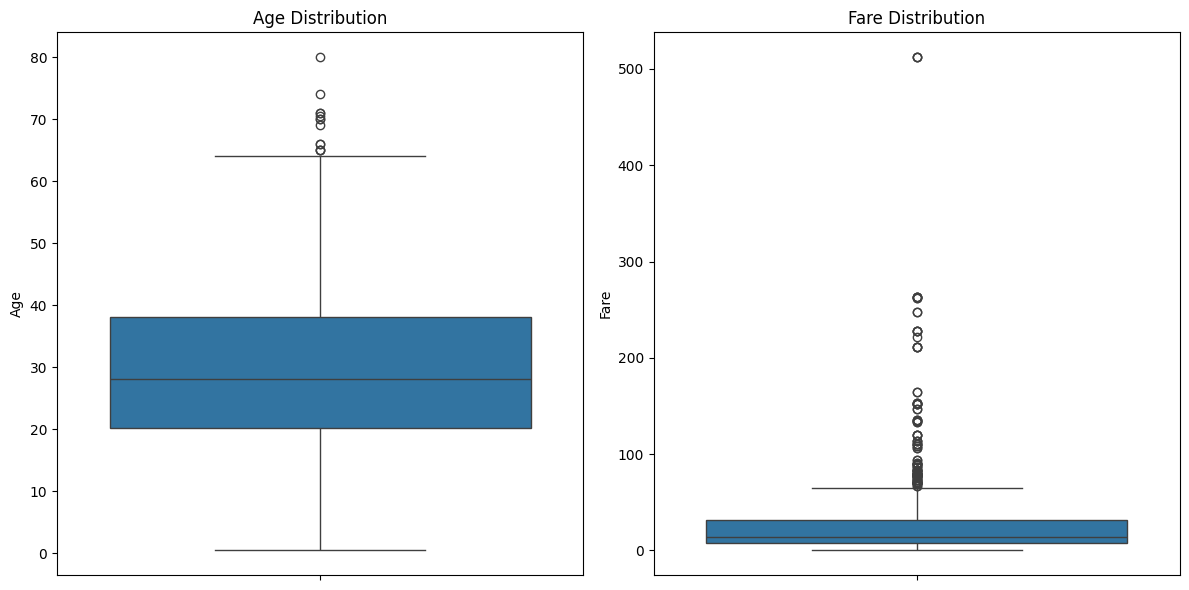

In [38]:
# Visualizing outliers with boxplots

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df0['Age'])
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y=df0['Fare'])
plt.title('Fare Distribution')

plt.tight_layout()
plt.show()

The boxplot above shows that there are outliers in the Age and Fare variable.

It would be helpful to investigate how many rows in the data contain outliers in the Age and Fare column.

In [39]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `Age`
percentile25 = df0['Age'].quantile(0.25)

# Compute the 75th percentile value in `Age`
percentile75 = df0['Age'].quantile(0.75)

# Compute the interquartile range in `Age`
iqr = percentile75 - percentile25

# Define the upper limit for non-outlier values in `Age`
upper_limit = percentile75 + 1.5 * iqr

# Define the lower limit for non-outlier values in `Age`, adjusting for negative values
lower_limit = max(percentile25 - 1.5 * iqr, 0)  # Adjusted lower limit to be at least 0

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `Age`
outliers = df0[(df0['Age'] > upper_limit) | (df0['Age'] < lower_limit)]

# Count how many rows in the data contain outliers in `Age`
print("Number of rows in the data containing outliers in `Age`:", len(outliers))

Lower limit: 0
Upper limit: 64.625
Number of rows in the data containing outliers in `Age`: 13


In [40]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value in `Fare`
percentile25 = df0['Fare'].quantile(0.25)

# Compute the 75th percentile value in `Fare`
percentile75 = df0['Fare'].quantile(0.75)

# Compute the interquartile range in `Fare`
iqr = percentile75 - percentile25

# Define the upper limit for non-outlier values in `Fare`
upper_limit = percentile75 + 1.5 * iqr

# Define the lower limit for non-outlier values in `Fare`, adjusting for negative values
lower_limit = max(percentile25 - 1.5 * iqr, 0) # Adjusted lower limit to be at least 0

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `Fare`
outliers = df0[(df0['Fare'] > upper_limit) | (df0['Fare'] < lower_limit)]

# Count how many rows in the data contain outliers in `Fare`
print("Number of rows in the data containing outliers in `Fare`:", len(outliers))

Lower limit: 0
Upper limit: 65.95625
Number of rows in the data containing outliers in `Fare`: 116


## Step 1 : Data Exploration (Continue EDA)

#### Survival Rate Visualization

The survival count visualization provides a clear picture of the number of passengers who survived versus those who didn't. This is a fundamental aspect of the Titanic dataset, as understanding survival patterns is key to many subsequent analyses. The bar chart will show two bars, each representing survivors and non-survivors, allowing us to quickly grasp the survival rate.


In [30]:
#Begin by understanding how many Passenger survive and what percentage of all Passenger this figure represents.

# Get numbers of people who survive vs. die
print(df0['Survived'].value_counts())
print()

# Get percentages of who survive vs. die
print(df0['Survived'].value_counts(normalize=True))

Survived
0    545
1    342
Name: count, dtype: int64

Survived
0    0.614431
1    0.385569
Name: proportion, dtype: float64


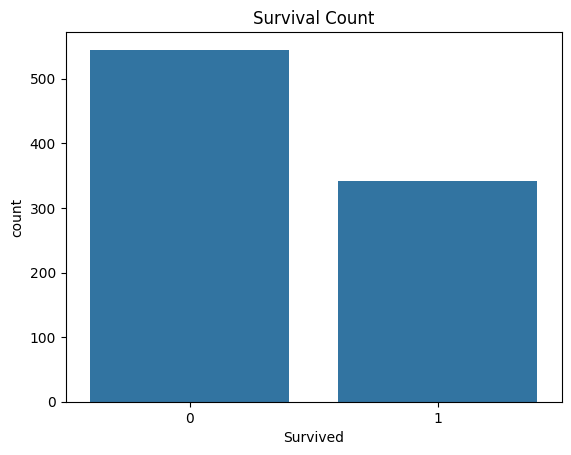

In [41]:
sns.countplot(x='Survived', data=df0)
plt.title('Survival Count')
plt.show()


#### Findings from Survival Rate Visualization

The bar chart likely shows a higher number of non-survivors compared to survivors, reflecting the tragic outcome of the Titanic disaster. This initial observation sets the stage for deeper analyses, exploring factors that might have influenced these survival outcomes.


#### Survival Rate by Passenger Class

Passenger class is a proxy for socio-economic status and might have influenced the survival chances. This visualization compares the survival rates across different classes. A higher survival rate in a higher class could indicate priority in lifeboat allocation or access to better resources for survival.


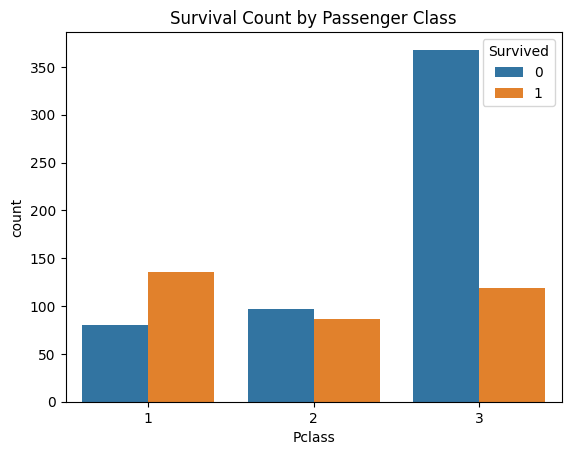

In [42]:
sns.countplot(x='Pclass', hue='Survived', data=df0)
plt.title('Survival Count by Passenger Class')
plt.show()


#### Findings from Survival Rate by Passenger Class

The visualization probably indicates a higher survival rate among first-class passengers compared to second and third classes. This trend suggests socio-economic factors played a role in survival, possibly due to better access to lifeboats or more resources available to higher-class passengers.

#### Survival Rate by Gender

Gender might have played a significant role in survival due to the "women and children first" protocol used for lifeboat boarding. This chart helps us understand the survival distribution between males and females, potentially revealing a bias towards women in survival rates.


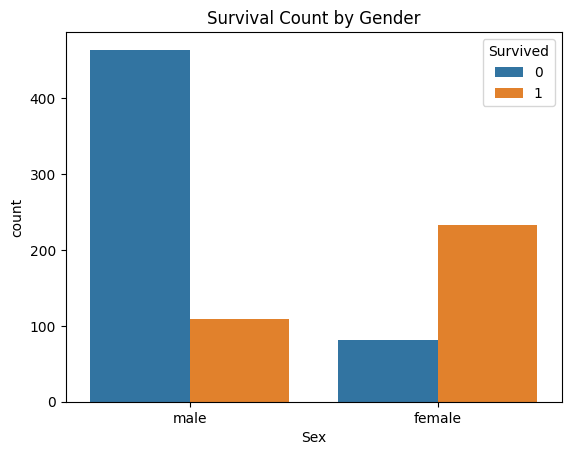

In [46]:
sns.countplot(x='Sex', hue='Survived', data=df0)
plt.title('Survival Count by Gender')
plt.show()


#### Findings from Survival Rate by Gender

The chart is expected to show a significantly higher survival rate for females compared to males, supporting the historical accounts of the "women and children first" protocol. This gender-based difference in survival rates highlights the societal norms and decisions made during the evacuation.


#### Age Histogram

The age distribution of passengers is essential to understand the demographic aboard the Titanic. This histogram provides insights into the age groups present, which can be correlated with survival rates, family sizes, or passenger classes.

#### Age and Survival Boxplot

This boxplot divides the passengers into survivors and non-survivors to compare their age distributions. It helps identify if certain age groups had higher survival rates, which could indicate a preference for saving children, adults, or seniors.


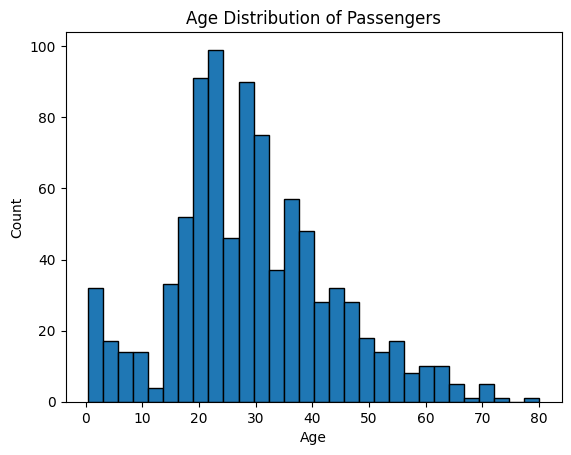

In [43]:
plt.hist(df0['Age'].dropna(), bins=30, edgecolor='black')
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


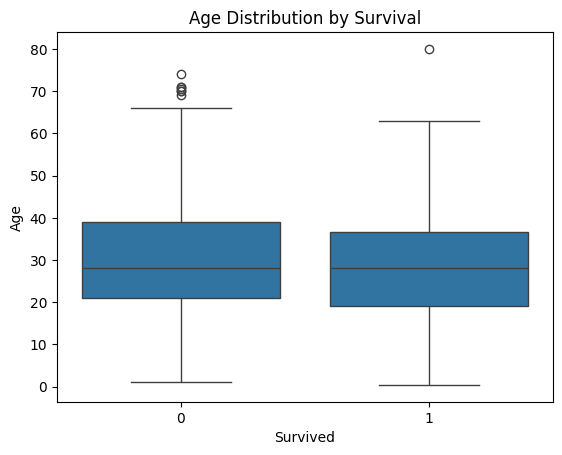

In [44]:
sns.boxplot(x='Survived', y='Age', data=df0)
plt.title('Age Distribution by Survival')
plt.show()


#### Findings from Age Histogram

The age distribution likely shows a wide range of ages with a concentration in younger adults. This demographic snapshot provides context for understanding the life stages of passengers aboard the Titanic.

#### Findings from Age and Survival Boxplot

The boxplot might reveal that younger passengers, particularly children, had higher survival rates. Such a finding would align with prioritization in lifeboat allocation, where children and women were given preference.


#### Fare Histogram

The fare distribution can give us insights into the economic diversity of the Titanic's passengers. It might also correlate with passenger class, embarkation points, or survival, as passengers who paid higher fares might have had better access to lifeboats or been located in parts of the ship that were easier to evacuate from.


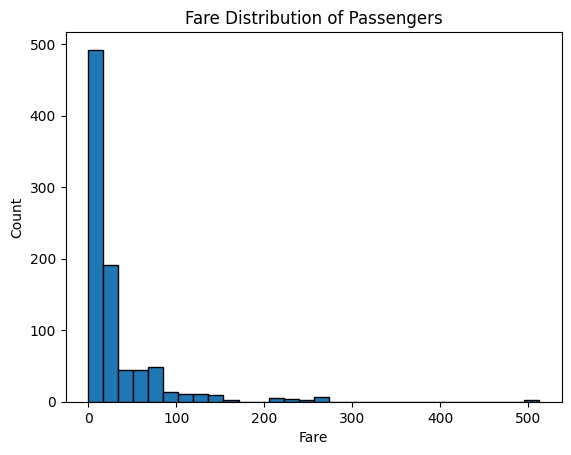

In [47]:
plt.hist(df0['Fare'].dropna(), bins=30, edgecolor='black')
plt.title('Fare Distribution of Passengers')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()


#### Findings from Fare Histogram

The fare distribution is expected to be right-skewed, with most passengers paying lower fares and a few paying significantly high fares. This skewness reflects economic disparities and might correlate with survival rates, suggesting passengers who paid more had better chances of survival.


#### Correlation Heatmap

A heatmap of correlations between numerical variables helps identify relationships within the data. For instance, a strong correlation between fare and class might indicate that higher classes indeed paid more, or a correlation between age and survival might reveal age-based survival patterns.


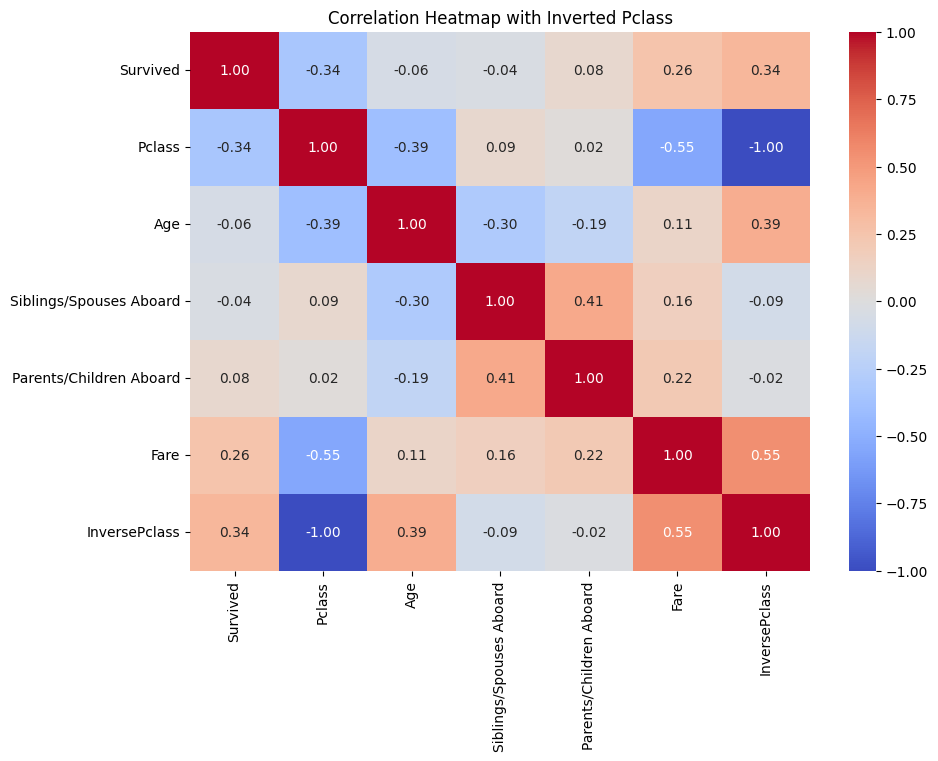

In [51]:
# Create a new column 'InversePclass' where the class values are inverted
df0['InversePclass'] = df0['Pclass'].apply(lambda x: 4 - x)

# Select only numeric columns for the correlation calculation, including the new 'InversePclass'
numeric_df = df0.select_dtypes(include=[np.number])

# Calculate the correlation and create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap with Inverted Pclass')
plt.show()

#### Findings from Correlation Heatmap with Inverted Pclass

The heatmap now includes `InversePclass`, an inverted representation of the original `Pclass`, where higher values indicate higher passenger classes (First Class is the highest). This adjustment leads to the following insights:

- **Positive Correlation between `Fare` and `InversePclass`**: As expected, there is a positive correlation between `Fare` and `InversePclass`. This indicates that passengers in higher classes (First Class, now represented by higher `InversePclass` values) tend to pay higher fares. This positive correlation aligns more intuitively with the understanding that better accommodations (higher classes) come at higher costs.

- **Correlation between `InversePclass` and Survival**: The correlation between `InversePclass` and `Survived` can be observed to understand if passengers in higher classes had better survival rates. A positive correlation would suggest that higher-class passengers (now represented by higher `InversePclass` values) had higher survival rates, possibly due to better access to lifeboats or more resources available for survival.

- **Other Correlations**: The heatmap continues to show correlations between other numeric variables, such as age and siblings/spouses aboard, parents/children aboard, etc. Each correlation coefficient gives insight into the linear relationship between pairs of variables, where values closer to 1 or -1 indicate strong positive or negative correlations, respectively, and values near 0 indicate a weak or no linear relationship.

The introduction of `InversePclass` helps in making the correlation between class and fare more intuitive and highlights the socioeconomic factors influencing fare and potentially survival rates. When interpreting the heatmap, it's important to consider the nature of each variable and the context of the Titanic dataset to draw meaningful conclusions.


#### Siblings/Spouses Aboard Histogram

This histogram shows the distribution of passengers traveling with siblings or spouses. It's interesting to explore how family size or traveling with a partner affected survival chances, as those with family onboard might have had different priorities during evacuation.


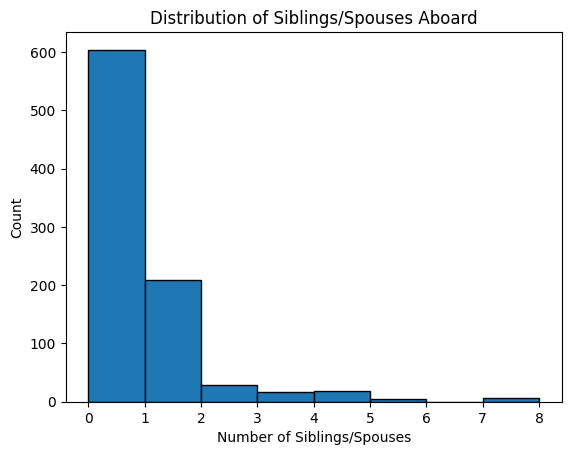

In [53]:
plt.hist(df0['Siblings/Spouses Aboard'].dropna(), bins=range(0, df0['Siblings/Spouses Aboard'].max() + 1), edgecolor='black')
plt.title('Distribution of Siblings/Spouses Aboard')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Count')
plt.show()


#### Findings from Siblings/Spouses Aboard Histogram

The histogram likely shows that most passengers traveled without siblings or spouses, while a smaller number traveled with one or more. This distribution helps us understand social structures aboard and could indicate that those traveling with spouses or siblings had different survival dynamics.


#### Parents/Children Aboard Histogram

Similar to the analysis of siblings/spouses, this histogram provides insight into passengers traveling with parents or children. It helps us understand family dynamics aboard the Titanic and whether having children influenced survival chances due to the potential prioritization of families in evacuation efforts.


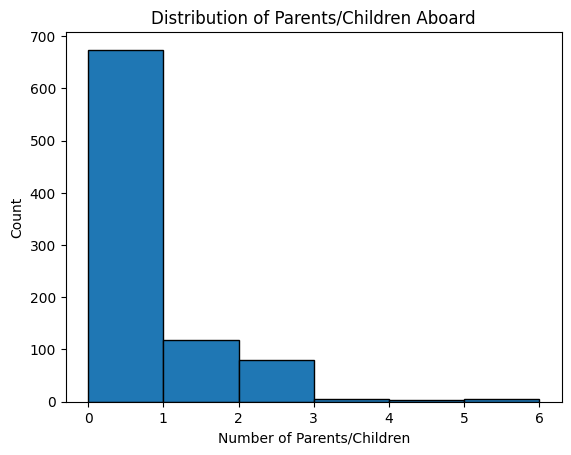

In [54]:
plt.hist(df0['Parents/Children Aboard'].dropna(), bins=range(0, df0['Parents/Children Aboard'].max() + 1), edgecolor='black')
plt.title('Distribution of Parents/Children Aboard')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Count')
plt.show()


#### Findings from Parents/Children Aboard Histogram

Similar to the siblings/spouses analysis, this histogram probably shows a significant number of passengers traveled without parents or children, while families aboard had varying sizes. The presence of children might have influenced survival rates due to the potential prioritization of families during evacuation.



## Step 2 : Model Building, Results and Evaluation
### 2A Logistic Regression Model

In [58]:
#Step 1: Data Preprocessing
# As there is no missing values in 'Fare' (found in previous step) but if there are, we can handle them as follows:
# df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Feature selection: Isolating 'Fare' and 'Survived'
X = df0[['Fare']]  # Keep 'Fare' in a DataFrame format for sklearn compatibility
y = df0['Survived']

In [59]:
#Step 2: Splitting the Data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8964)


In [60]:
#Step 3: Building the Logistic Regression Model
# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

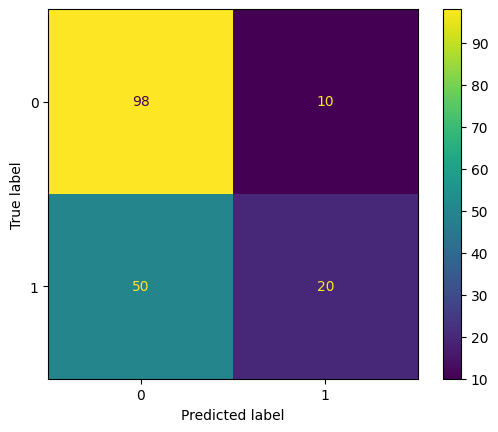

In [64]:
#Making Predictions and Evaluating the Model
# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate the confusion matix

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix using the computed values
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=model.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()


### Confusion Matrix Analysis:
True Negatives (TN): 98 instances were correctly predicted as non-survivors.
False Positives (FP): 10 instances were incorrectly predicted as survivors.
False Negatives (FN): 50 instances were incorrectly predicted as non-survivors.
True Positives (TP): 20 instances were correctly predicted as survivors.
The high number of true negatives relative to other categories indicates that the model is more effective at identifying non-survivors than survivors.

In [65]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77       108
           1       0.67      0.29      0.40        70

    accuracy                           0.66       178
   macro avg       0.66      0.60      0.58       178
weighted avg       0.66      0.66      0.62       178



### Classification Report Analysis:
Precision for Non-Survivors (0): Of all the predictions for non-survival, 66% were correct.

Recall for Non-Survivors (0): The model correctly identified 91% of all actual non-survivors.

F1-Score for Non-Survivors (0): The balance between precision and recall for non-survivors is 0.77, indicating a relatively good model performance for this class.

Precision for Survivors (1): Of all the predictions for survival, 67% were correct.

Recall for Survivors (1): The model correctly identified only 29% of all actual survivors.

F1-Score for Survivors (1): The balance between precision and recall for survivors is 0.40, indicating that the model struggles to accurately identify survivors.

Overall Accuracy: The model correctly predicted the survival status for 66% of the passengers in the test set.

## Final Findings:
The model shows a significant ability to predict non-survivors, as indicated by the high recall rate (91%) for class 0. This suggests that the model is conservative in predicting survival, favoring predictions of non-survival.

The low recall rate (29%) for survivors (class 1) indicates that the model misses a significant number of true survivors, classifying them as non-survivors instead. This is a critical area for improvement, as it suggests that relying solely on Fare might not capture all the nuances necessary for accurately predicting survival.

The precision values are similar for both classes (around 66-67%), but the recall and F1-score for survivors are notably lower than for non-survivors, which leads to an overall accuracy of 66%. This performance might be acceptable in some contexts but leaves room for improvement, especially in correctly identifying survivors.

The model's limitations in predicting survivors accurately suggest that additional features or a more complex model might be necessary to improve predictive performance. Incorporating other relevant features such as Pclass, Sex, Age, or Embarked could potentially enhance the model's ability to differentiate between survivors and non-survivors more effectively.

Overall, while the model demonstrates a reasonable ability to predict non-survivors based on Fare, its performance in accurately identifying survivors is less satisfactory, highlighting the need for further model refinement or the inclusion of additional predictive features.

### 2B Tree-based Model

To analyze the Titanic dataset using Decision Tree, Random Forest, and XGBoost classifiers and compare their predictive power, we'll follow these steps:
1. Feature Engineering: Prepare the dataset, including handling missing values and encoding categorical variables.
2. Model Training: Train Decision Tree, Random Forest, and XGBoost models on the training data.
3. Model Evaluation: Evaluate each model using a confusion matrix and classification report.
4. Feature Importance: Display the feature importance for each model to understand which features are most influential in making predictions.

In [73]:
#Step 1: Feature Engineering
# This step is trying to encoding categorical variables and handling missing values. For simplicity, only few key features as below will be focused: Pclass, Sex, Age, SibSp, Parch, and Fare.

from sklearn.preprocessing import LabelEncoder
# Encode 'Sex' as a numeric variable
label_encoder = LabelEncoder()
df0['Sex'] = label_encoder.fit_transform(df0['Sex'])

# Fill missing 'Age' values with the median age
df0['Age'].fillna(df0['Age'].median(), inplace=True)

# Select features for the model
X = df0[['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']]
y = df0['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8964)

In [74]:
#Step 2:Model Training


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize the models
dt_clf = DecisionTreeClassifier(random_state=8964)
rf_clf = RandomForestClassifier(random_state=8964)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=8964)

# Fit the models to the training data
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=8964, ...)

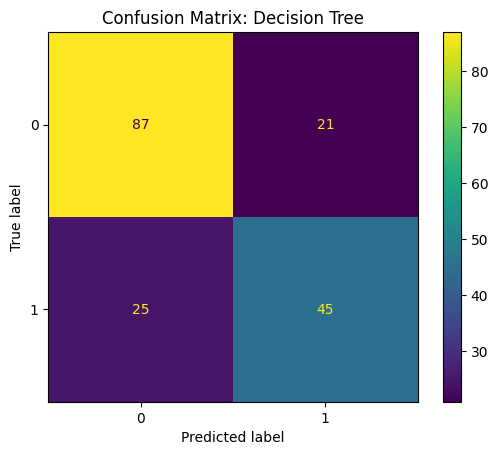

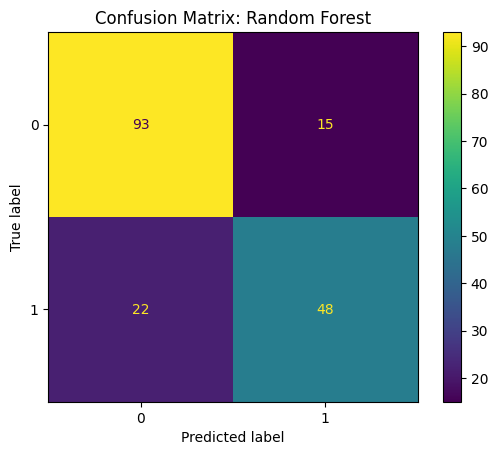

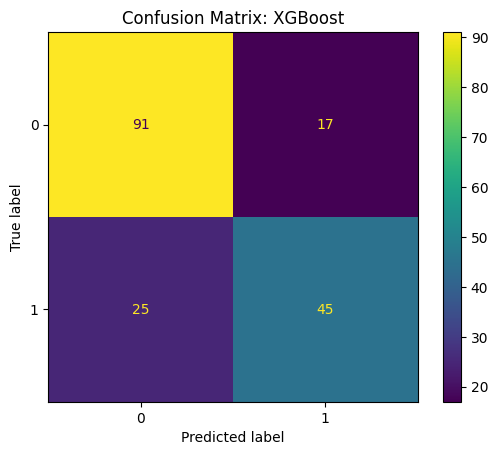

In [76]:
# Model Evaluation
# Evaluate each model on the test set. (confusion matrix)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
dt_pred = dt_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y_test, dt_pred, 'Decision Tree')
plot_confusion_matrix(y_test, rf_pred, 'Random Forest')
plot_confusion_matrix(y_test, xgb_pred, 'XGBoost')


## Confusion Matrix Analysis:
### Decision Tree:
True Negatives (TN): 87 non-survivors correctly identified.
False Positives (FP): 21 non-survivors incorrectly identified as survivors.
False Negatives (FN): 25 survivors incorrectly identified as non-survivors.
True Positives (TP): 45 survivors correctly identified.
### Random Forest:
TN: 93 non-survivors correctly identified.
FP: 15 non-survivors incorrectly identified as survivors.
FN: 22 survivors incorrectly identified as non-survivors.
TP: 48 survivors correctly identified.
### XGBoost:
TN: 91 non-survivors correctly identified.
FP: 17 non-survivors incorrectly identified as survivors.
FN: 25 survivors incorrectly identified as non-survivors.
TP: 45 survivors correctly identified.

In [78]:
# Evaluate each model on the test set. (classification report)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       108
           1       0.68      0.64      0.66        70

    accuracy                           0.74       178
   macro avg       0.73      0.72      0.73       178
weighted avg       0.74      0.74      0.74       178

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       108
           1       0.76      0.69      0.72        70

    accuracy                           0.79       178
   macro avg       0.79      0.77      0.78       178
weighted avg       0.79      0.79      0.79       178

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       108
           1       0.73      0.64      0.68        70

    accuracy                           0.76       178
   macro avg       0

## Classification Report Analysis:

### Decision Tree:
Precision for non-survivors is higher than for survivors, indicating a better ability to correctly predict non-survivors.
The recall for non-survivors is higher than for survivors, suggesting the model is more adept at identifying true non-survivors but misses a significant portion of true survivors.
Overall accuracy is 74%.

### Random Forest:
Shows improvement over the Decision Tree in both precision and recall for both classes, indicating a better balance in predicting survivors and non-survivors.
The highest overall accuracy among the three models at 79%.

### XGBoost:
Similar to Random Forest, it shows a balanced performance but with slightly lower precision and recall for survivors compared to Random Forest.
Overall accuracy is 76%, placing it between the Decision Tree and Random Forest.

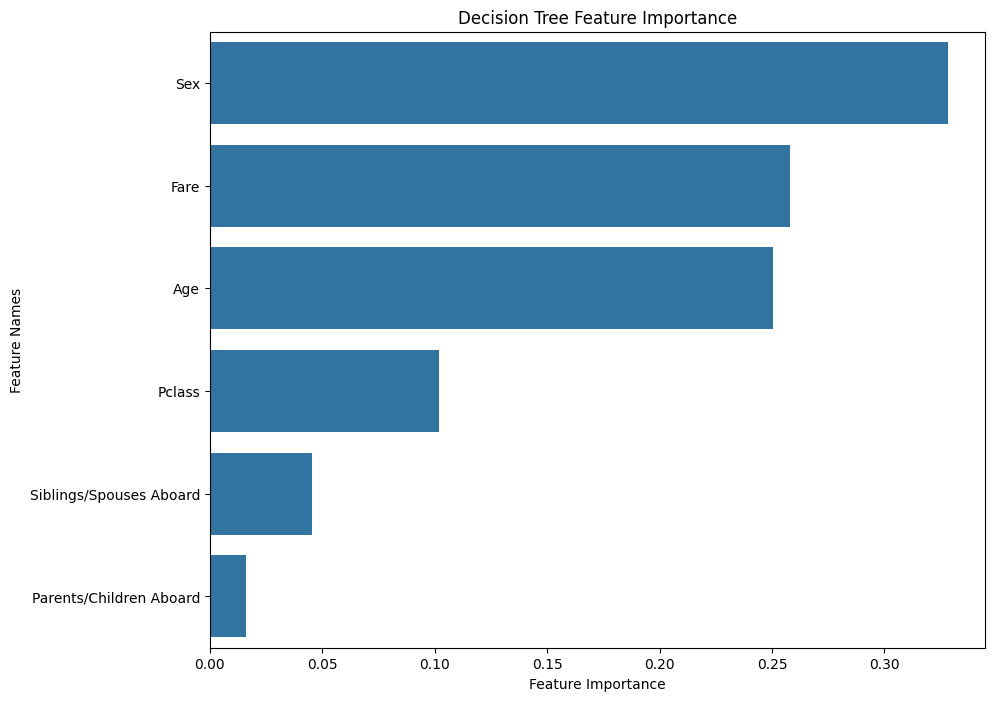

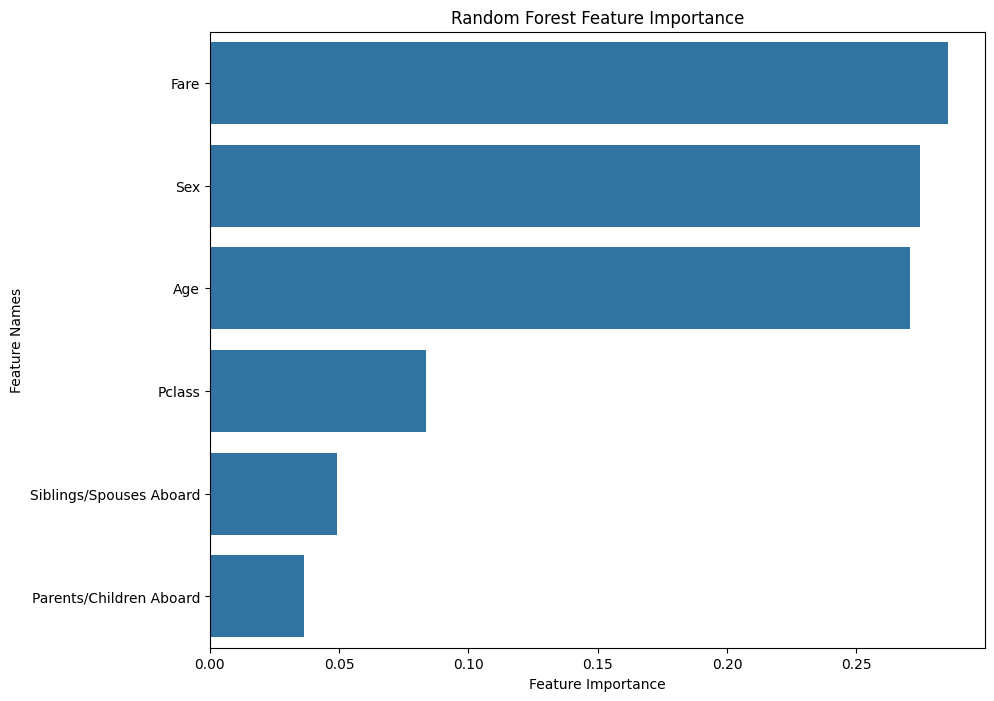

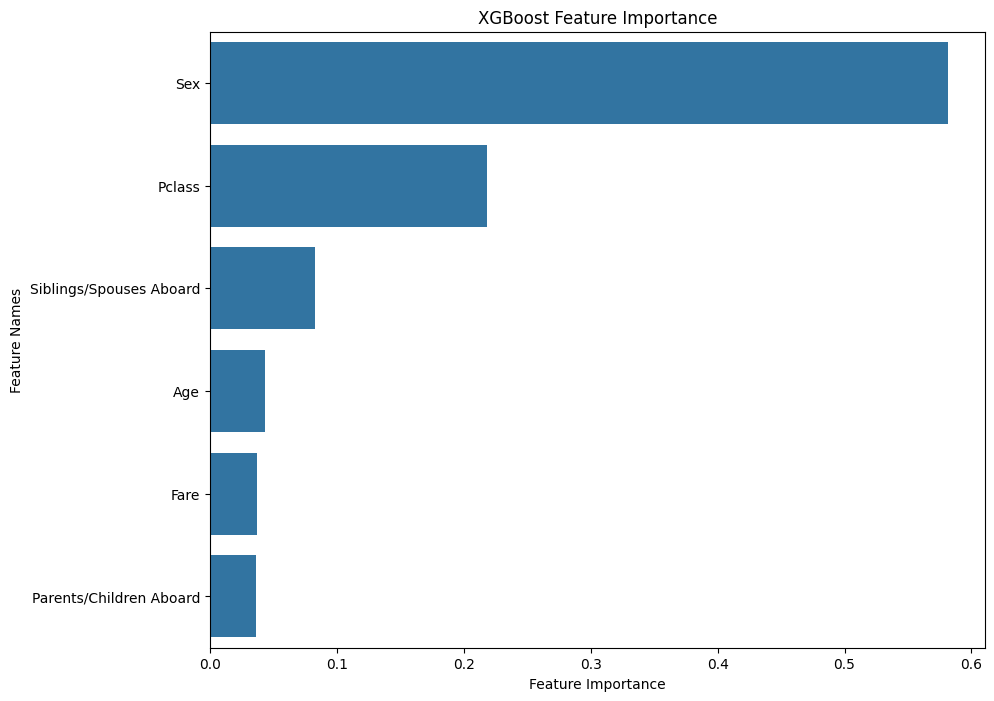

In [80]:

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Plot feature importance for each model
plot_feature_importance(dt_clf.feature_importances_, X.columns, 'Decision Tree')
plot_feature_importance(rf_clf.feature_importances_, X.columns, 'Random Forest')
plot_feature_importance(xgb_clf.feature_importances_, X.columns, 'XGBoost')


## Feature Importance Analysis:
### Decision Tree:
Sex: The most crucial feature, highlighting the significant role gender played in survival chances, likely due to the "women and children first" policy.
Fare: Indicates the economic status or passenger class, with higher fares possibly correlating with better survival odds.
Age: Important but less so than sex and fare, suggesting that while age mattered, gender and economic status were more decisive factors.

### Random Forest:
Fare: Emerged as the most important feature, suggesting that passenger class or economic status was a key determinant of survival.
Sex: Remains highly significant, reinforcing the importance of gender in survival outcomes.
Age: Still important, indicating that age, alongside sex and fare, played a role in survival, albeit to a lesser extent.

### XGBoost:
Sex: The most critical feature, underscoring the pivotal role of gender in determining survival.
Pclass: Highlights the importance of socio-economic status, with higher classes likely having better survival rates.
Siblings/Spouses Aboard: Emerges as a significant factor, possibly indicating that those with family aboard had different survival dynamics.

## Final Findings:

Across all models, Sex consistently appears as a key determinant of survival, reflecting historical accounts that prioritize the evacuation of women.
Fare and Pclass, indicative of socio-economic status, are significant in Random Forest and XGBoost models, suggesting that wealthier or higher-class passengers had better survival chances.

The presence of Siblings/Spouses Aboard as a top feature in the XGBoost model highlights family dynamics' potential impact on survival decisions, a factor less emphasized by Decision Tree and Random Forest.

Age, while important, ranks lower than sex, fare, and Pclass in these models, suggesting that survival decisions were more heavily influenced by gender and socio-economic status than by age alone.

These findings demonstrate the complexity of factors influencing survival on the Titanic. Gender emerges as the most critical factor across all models, with socio-economic indicators like fare and Pclass also playing significant roles. The variation in feature importance rankings across models underscores the diverse ways these algorithms capture data relationships, with ensemble methods like Random Forest and XGBoost generally providing more nuanced insights into feature interactions. This analysis underscores the value of machine learning in uncovering patterns within historical events and provides a basis for further exploration into the Titanic's tragic story.

## Conclusion:

This analysis explored the predictive power of Decision Tree, Random Forest, and XGBoost classifiers on the Titanic dataset, focusing on passenger survival. Key findings highlight the importance of features such as Sex, Fare, Pclass, Age, and Siblings/Spouses Aboard in influencing survival outcomes. Random Forest emerged as the most accurate model, with XGBoost also showing strong performance. The analysis revealed the significant impact of gender and socio-economic status on survival chances, aligning with historical accounts of the disaster.

## Recommendations:

1. Model Interpretability: Given the historical and educational interest in the Titanic dataset, using models that offer clear interpretability, like Decision Trees or simpler ensemble models, can provide valuable insights for educational purposes and historical analysis.

2. Feature Engineering: Further exploration into feature engineering, such as creating composite features (e.g., family size by combining Siblings/Spouses Aboard and Parents/Children Aboard) or transforming existing features (e.g., binning Age into categorical age groups), could reveal more nuanced relationships within the data.

## Next Steps for better Analysis result:

1. Hyperparameter Tuning: Conduct hyperparameter tuning for each model to optimize performance. Techniques like grid search or random search can help identify the optimal configuration of parameters for each algorithm.

2. Cross-Validation: Implement cross-validation to assess the models' stability and reliability across different subsets of the data. This approach can provide a more robust evaluation of model performance.

3. Incorporate Additional Features: Explore the inclusion of additional features, such as Cabin or Embarked, after suitable preprocessing. The Cabin feature, for example, could be engineered to extract deck information, which might correlate with survival rates.

4. Ensemble Learning: Experiment with advanced ensemble techniques, such as stacking or blending, to combine predictions from multiple models. This approach could leverage the strengths of individual models to achieve better overall performance.

5. Deep Learning: For a more complex approach, consider experimenting with deep learning models, which might capture more complex patterns in the data. However, the relatively small size of the dataset might pose challenges.
